## Importing libraries

In [1]:
# Some standard libraries
import numpy as np
import matplotlib.pyplot as plt

# Libraries for defining molecule
from functools import partial
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

# Libraries for solving electronic structure problem
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper
from qiskit_nature import settings
settings.dict_aux_operators = True

# Libraries for creating, running and visualizing quantum circuits 
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import BasicAer
from qiskit.circuit import Parameter
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from IPython.display import display, Math, clear_output

# OpenFermion
from openfermion.chem import MolecularData
from openfermionpsi4 import run_psi4
from openfermion.transforms import get_fermion_operator, bravyi_kitaev

## Quantum circuit (ansatz) and Expectation values

### Circuit

Quantum circuits for calculating $\langle IZ \rangle$, $\langle ZI \rangle$, $\langle XX \rangle$, $\langle YY \rangle$ and $\langle ZZ \rangle$, for different Z-gate angles $\theta$, so that a minimal energy ($\min_{\theta}\langle H \rangle$ can be found. For this we need 3 circuits which respectively measure $XX$, $YY$ and $ZZ$ (measuring $I$ alway yields 1), which is done by rotating the x- and y-axis respectively to the z-axis using a Hadamard ($\begin{pmatrix}1 & 1 \\ 1 & -1\end{pmatrix}/\sqrt{2}$) and a Phase and Hadamard gate $\begin{pmatrix}1 & 1 \\ i & -i\end{pmatrix}/\sqrt{2}$ (the columns of these operators are the z-eigenstates ($\left|0\right\rangle$, $\left|1\right\rangle$) expressed in x- respective y-eigenstates ($\frac{\left|0\right\rangle + \left|1\right\rangle}{\sqrt{2}}$, $\frac{\left|0\right\rangle - \left|1\right\rangle}{\sqrt{2}}$ and $\frac{\left|0\right\rangle + i\left|1\right\rangle}{\sqrt{2}}$, $\frac{\left|0\right\rangle - i\left|1\right\rangle}{\sqrt{2}}$) and thus form the conversion between bases like we want).

In [2]:
def measure_in_basis(qc,q,c,basis='z'):
    """Add quantum measurement in `basis` ('x','y','z') to quantum circuit `qc`
       on quantum- and classical register `q` and `c`"""
    if basis == 'x':
        qc.h(q)
    elif basis == 'y':
        qc.sdg(q)
        qc.h(q)
    qc.measure(q,c)

# Gates
def circuit(theta, qc, q, c, basis):
    qc.x(q[0])             # initialise in |01>
    qc.barrier(q)
    
    qc.rx(-3*np.pi/2,q[0]) #-X(pi/2) gate
    qc.ry(np.pi/2,q[1])    # Y(pi/2) gate
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.rz(theta,q[0])      # Z(theta) gate with theta suggested by classical optimizer
    qc.cnot(q[1],q[0])     # CNOT 1->0
    qc.ry(-3*np.pi/2,q[1]) #-Y(pi/2) gate
    qc.rx(np.pi/2,q[0])    # X(pi/2) gate
    qc.barrier(q)
    
    measure_in_basis(qc,q,c,basis)

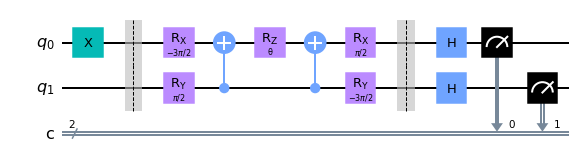

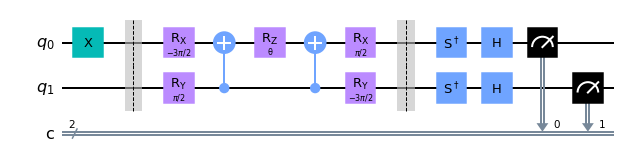

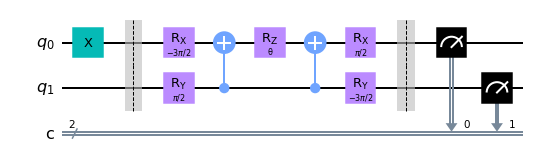

In [3]:
n = 2                          # number of qubits
q = QuantumRegister(n,'q')     # quantum register of n qubits
c = ClassicalRegister(n,'c')   # classical register of 1 bit
qc = {'x':QuantumCircuit(q,c), # create 3 quantum circuits
      'y':QuantumCircuit(q,c),
      'z':QuantumCircuit(q,c)}

theta = Parameter('θ') # create a variable for the z-rotation gate

# Apply gates to circuit for each basis measured in
for basis in ['x','y','z']:
    circuit(theta, qc[basis], q, c, basis)
    display(qc[basis].draw(output='mpl'))

In [4]:
def create_probabilities(state_distribution):
    """Calculate normalised probability distribution from a state counts array"""
    return state_distribution / np.sum(state_distribution)

def run_simulation(qc, q, c, theta_range, shots=1024, backend=BasicAer.get_backend('qasm_simulator')):
    """
    Run through the given quantum circuits getting state counts and probabilities
    
    Arguments:
    - qc: dict( str(basis): QuantumCircuit(q,c) ), dictionary of quantum registers 
    for all bases measured in, with quantum circuit already applied
    - q: QuantumRegister
    - c: ClassicalRegister
    - theta_range: np.ndarray or list, theta's to be evaluated
    - backend: quantum backend
    
    Returns:
    - counts: dict(str(basis): list( dict( str(state): int(count) ) ) )
    - probabilities: dict( str(basis): ??)
    """
    
    circuits = {}; counts = {}; probabilities = {}
    for basis in qc:
        circuits[basis] = [qc[basis].bind_parameters({theta: theta_val}) for theta_val in theta_range]
        job = execute(transpile(circuits[basis], backend),backend,shots=shots)
        counts[basis] = job.result().get_counts()
        probabilities[basis] = []
        for res in job.result().results:
            local_count = res.data.counts
            distribution = np.zeros(4)
            for key in local_count:
                distribution[int(key, 16)] += local_count[key]
            probabilities[basis].append(create_probabilities(distribution))
    
    return counts, probabilities

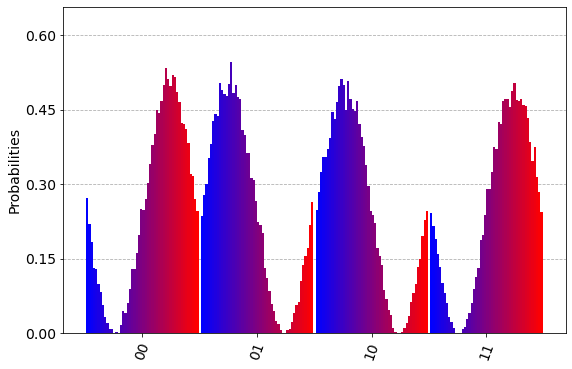

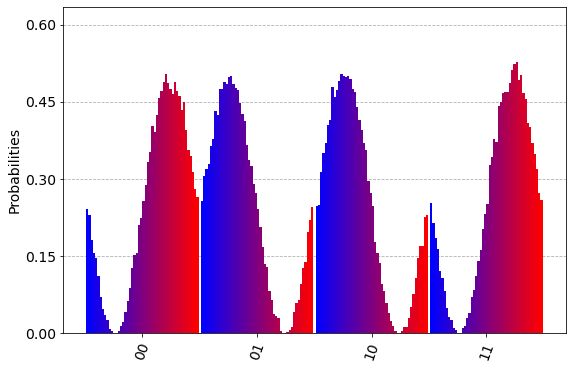

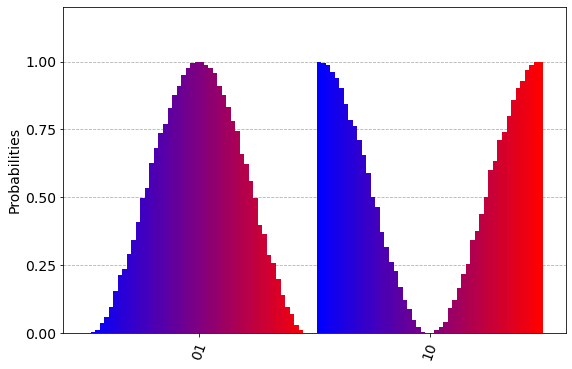

In [5]:
# Produce state histograms for the xx, yy and zz measurements
# Simulation
theta_points = 50
theta_range = np.linspace(0,2*np.pi,theta_points)
counts, probabilities = run_simulation(qc, q, c, theta_range)

# Plot
def color_gradient(rrange,grange,brange):
    R = np.linspace(*rrange,theta_points)
    G = np.linspace(*grange,theta_points)
    B = np.linspace(*brange,theta_points)
    return [(r,g,b) for r,g,b in zip(R,G,B)]
cmap = color_gradient([0,1],[0,0],[1,0])

for basis in ['x','y','z']:
    fig = plot_histogram(counts[basis],figsize=(9,6),color=cmap,bar_labels=False)
    fig.patch.set_facecolor('white')
    display(fig)

### Expectation values

In [6]:
# Compute expectations from probabilities
# if we define a 2qubit state as a|00> + b|01> + c|10> + d|11> we get:
def zi(prob):
    """<ZI> = |a|^2 + |b|^2 - |c|^2 - |d|^2""" 
    return prob[0] + prob[1] - prob[2] - prob[3]

def iz(prob):
    """<IZ> = |a|^2 - |b|^2 + |c|^2 - |d|^2"""
    return prob[0] - prob[1] + prob[2] - prob[3]

def xx_yy_zz(prob):
    """<ZZ> = |a|^2 - |b|^2 - |c|^2 + |d|^2
    (since we flip the x- and y basis to the z-axis for measurement, we can input the
    xx and yy probabilities and use the same calculation for <XX> and <YY> as for <ZZ>)"""
    return prob[0] - prob[1] - prob[2] + prob[3]

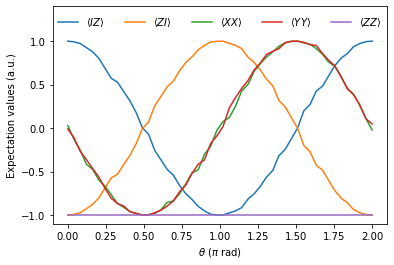

In [7]:
expectation_values = {'II': np.ones(theta_points), 
                      'IZ': np.zeros(theta_points), 
                      'ZI': np.zeros(theta_points), 
                      'XX': np.zeros(theta_points), 
                      'YY': np.zeros(theta_points), 
                      'ZZ': np.zeros(theta_points)}

for index, theta in enumerate(theta_range):
    exp_zi = zi(probabilities['z'][index])
    exp_iz = iz(probabilities['z'][index])
    exp_xx = xx_yy_zz(probabilities['x'][index])
    exp_yy = xx_yy_zz(probabilities['y'][index])
    exp_zz = xx_yy_zz(probabilities['z'][index])
    expectation_values['IZ'][index] = exp_iz
    expectation_values['ZI'][index] = exp_zi
    expectation_values['XX'][index] = exp_xx
    expectation_values['YY'][index] = exp_yy
    expectation_values['ZZ'][index] = exp_zz

plt.figure()
plt.xlabel(r'$\theta$ ($\pi$ rad)')
plt.ylabel('Expectation values (a.u.)')
for key in expectation_values:
    if key!='II': 
        plt.plot(theta_range/np.pi, expectation_values[key], label=r'$\langle '+key+r' \rangle$')
plt.ylim(-1.1,1.4)
plt.legend(loc='upper center',ncol=5,frameon=False)
plt.show()

This graph clearly matches figure 5c of [Xue](https://arxiv.org/abs/2107.00628). The noise in our graph is due to a too-low sampling rate of 1024 samples per value of $\theta$.

## Qiskit Hamiltonian (Psi4 driver)

In [8]:
R = 0.7414                # supposed internuclear spacing in ground
R_points = 30             # number of R-points evaluated
R_min, R_max = 0.20, 2.85 # boundaries of R-range evaluated
R_range = np.linspace(R_min,R_max,R_points)

distance = partial(Molecule.absolute_distance, atom_pair=(1, 0)) # distance operation on molecule

# Define molecule and driver and create electronic structure problem
molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, R]]], charge=0, multiplicity=1,
    degrees_of_freedom=[distance]
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PSI4
)
es_problem = ElectronicStructureProblem(driver)

In [9]:
def get_QK_hamiltonian(molecule, es_problem, mapper, two_qubit_reduction=False, z2symmetry_reduction=None):
    """
    Gets qubit Hamiltonian from molecule and electronic-structure problem
    and prints z2symmetries if applicable.
    
    Arguments:
    - molecule: Molecule() instance
    - es_problem: ElectronicStructureProblem() instance corresponding to molecule
    - mapper: Instance of mapper from Fermionic Operator to Qubit Operator, can be 
    JordanWignerMapper(), BravyiKitaevMapper() or ParityMapper() 
    - two_qubit_reduction (bool): Whether to carry out two qubit reduction when possible
    - z2symmetry_reduction (list( int(1 or -1) )): Indicates whether a z2 symmetry 
    reduction should be applied
    
    Returns:
    - Hamiltonian (dict( str(operator): complex(coefficient) )
    """
    second_q_op = es_problem.second_q_ops()
    qubit_converter = QubitConverter(mapper=mapper, 
                                     two_qubit_reduction=two_qubit_reduction, 
                                     z2symmetry_reduction=z2symmetry_reduction)
    qubit_op = qubit_converter.convert(second_q_op['ElectronicEnergy'], num_particles=es_problem.num_particles)
    if z2symmetry_reduction != None: print(qubit_converter.z2symmetries)
    return dict(qubit_op.primitive.to_list())

### Bravyi-Kitaev transformed Hamiltonian

In [10]:
BK_qiskit = get_QK_hamiltonian(molecule, es_problem, BravyiKitaevMapper(), 
                              z2symmetry_reduction=None)
BK_qiskit

{'IIII': (-0.8126179631346924+0j),
 'IZII': (0.17119774898057477+0j),
 'IIZI': (0.12054482203290015+0j),
 'ZIZI': (0.12054482203290015+0j),
 'ZZZI': (-0.22278593024287527+0j),
 'IIIZ': (0.17119774898057483+0j),
 'IZIZ': (0.16862219157249933+0j),
 'ZZIZ': (0.17434844183963846+0j),
 'IIZZ': (-0.2227859302428753+0j),
 'IZZZ': (0.16586702409067788+0j),
 'ZZZZ': (0.16586702409067788+0j),
 'IXIX': (0.0453222020577777+0j),
 'ZXIX': (0.0453222020577777+0j),
 'IXZX': (-0.0453222020577777+0j),
 'ZXZX': (-0.0453222020577777+0j)}

### Reduced parity transformed Hamiltonian

In [11]:
P_qiskit = get_QK_hamiltonian(molecule, es_problem, ParityMapper(), 
                              two_qubit_reduction=True, z2symmetry_reduction=None)
P_qiskit

{'II': (-1.0537076072004925+2.7755575615628914e-17j),
 'ZI': (-0.3939836792234499+0j),
 'IZ': (0.39398367922344996+1.3877787807814457e-17j),
 'ZZ': (-0.011236585230781998+0j),
 'XX': (0.1812888082311108+3.469446951953614e-18j)}

Should be real values, however, the imaginary parts are an order $10^{17}$ smaller than the real parts. We thus can assume these are artifacts from imperfect numerical calculations

## OpenFermion Hamiltonian

In [12]:
def manual_bk_reduction(bk):
    """Reduces the 4 qubit BK Hamiltonian to 2 qubits using known symmetries"""
    II_coef = bk.terms[()] + bk.terms[((1,'Z'),)] + bk.terms[((1,'Z'), (3,'Z'))]
    ZI_coef = bk.terms[((0,'Z'),)] + bk.terms[((0,'Z'), (1,'Z'))]
    IZ_coef = bk.terms[((2,'Z'),)] + bk.terms[((1,'Z'), (2,'Z'), (3,'Z'))]
    ZZ_coef = bk.terms[((0,'Z'), (1,'Z'), (2,'Z'), (3,'Z'))] + bk.terms[((0,'Z'), (2,'Z'))] + bk.terms[((0,'Z'), (1,'Z'), (2,'Z'))] + bk.terms[((0,'Z'), (2,'Z'), (3,'Z'))]
    XX_coef = bk.terms[((0,'X'), (1,'Z'), (2,'X'), (3,'Z'))] + bk.terms[((0,'X'), (1,'Z'), (2,'X'))]
    YY_coef = bk.terms[((0,'Y'), (1,'Z'), (2,'Y'), (3,'Z'))] + bk.terms[((0,'Y'), (1,'Z'), (2,'Y'))]
    return {'II':II_coef, 'ZI':ZI_coef, 'IZ':IZ_coef, 'ZZ':ZZ_coef, 'XX':XX_coef, 'YY':YY_coef}

def bk_to_dict(bk,number_of_qubits=4):
    """Transforms the BK Hamiltonian calculated by OpenFermion to a
       dictionary of structure dict( str(operator) : complex(coefficient) )"""
    temp = {}
    data = {}
    split_hamiltonian_string = str(bk).split(' +\n')
    m = 0
    for line in split_hamiltonian_string:
        s = line.split('[')
        s[1] = s[1][:-1]
        value = np.complex128(s[0][1:-2]).real
        if s[1] == '':
            temp[s[1]] = value
            continue
        measurements = s[1].split(' ')
        key = ','.join([k for k in measurements])
        temp[key] = value
        m = m if int(measurements[-1][1:]) < m else int(measurements[-1][1:])
    for key in temp:
        new_key = []
        for i in range(m+1):
            new_key.append(0)
        if key != '':
            for k in key.split(','):
                new_key[int(k[1:])] = k[0]
        for i in range(m+1):
            if new_key[i] == 0:
                new_key[i] = 'I'
        data[''.join(new_key)] = temp[key]
    return data

In [13]:
def get_OF_hamiltonian(molecule,symmetry_reduction=False,basis='sto-3g'):
    h2_molecule_data = MolecularData(molecule.geometry, basis, molecule.multiplicity, molecule.charge)
    h2_molecule = run_psi4(h2_molecule_data,
                           run_scf = True,
                           run_mp2 = True,
                           run_cisd = False,
                           run_ccsd = False,
                           run_fci = True)
    h2_molecule_fermion_operator = get_fermion_operator(h2_molecule.get_molecular_hamiltonian())
    bk = bravyi_kitaev(h2_molecule_fermion_operator)
    if symmetry_reduction: 
        return manual_bk_reduction(bk)
    else:
        return bk_to_dict(bk)

### Bravyi-Kitaev transformed Hamiltonian

In [14]:
BK_openfermion = get_OF_hamiltonian(molecule, symmetry_reduction=False)
BK_openfermion

{'IIII': -0.09886396978427466,
 'XZXI': 0.045322202057777705,
 'XZXZ': 0.045322202057777705,
 'YZYI': 0.045322202057777705,
 'YZYZ': 0.045322202057777705,
 'ZIII': 0.1711977489805749,
 'ZZII': 0.17119774898057494,
 'ZZZI': 0.16586702409067788,
 'ZZZZ': 0.16586702409067788,
 'ZIZI': 0.12054482203290019,
 'ZIZZ': 0.12054482203290019,
 'IZII': 0.16862219157249933,
 'IZZZ': -0.2227859302428754,
 'IZIZ': 0.17434844183963846,
 'IIZI': -0.22278593024287535}

In [15]:
BK_reduced_openfermion = get_OF_hamiltonian(molecule, symmetry_reduction=True)
BK_reduced_openfermion

{'II': (0.24410666362786315+0j),
 'ZI': (0.3423954979611499+0j),
 'IZ': (-0.44557186048575076+0j),
 'ZZ': (0.5728236922471561+0j),
 'XX': (0.09064440411555541+0j),
 'YY': (0.09064440411555541+0j)}

## Ground state solver using VQE

In [16]:
def plot_results(R_range,theta_range,E0,E, label=None,additional_curves=None):
    plt.figure(figsize=(12,4))
    plt.subplot(121,box_aspect=0.7)
    plt.xlabel(r'Internuclear distance $R$ (Å)')
    plt.ylabel(r'Ground state energy $\langle E_0 \rangle$ (Ha)')
    plt.plot(R_range,E0,label=label)
    if additional_curves:
        try:
            for tup in additional_curves:
                curve,label = tup
                plt.plot(R_range,curve,label=label)
                plt.legend()
        except:
            print("Could not plot additional curves. Data type should be list( tuple( <np.ndarray or list>, str(label) ) )")

    plt.subplot(122,aspect=1)
    plt.xlabel(r'Internuclear distance $R$ (Å)')
    plt.ylabel(r'$\theta$ ($\pi$ rad)')
    plt.plot(R_range,theta_range[np.argmin(E,axis=0)]/np.pi,c='white',lw=2)
    im = plt.imshow(E,extent=[min(R_range),max(R_range),min(theta_range)/np.pi,max(theta_range)/np.pi],
                    cmap='gnuplot',aspect=1.25,origin='lower')
    plt.colorbar(im,label=r'$\langle E \rangle$ (Ha)')
    plt.show()

### Qiskit

In [17]:
def Qiskit_gss(molecule, es_problem, distance, expectation_values):
    """Ground state solver using manual energy minimisation"""
    molecule.perturbations = [distance]
    
    # Get Hamiltonian
    Hamiltonian = get_QK_hamiltonian(molecule,es_problem,ParityMapper(),True)

    E = 0 # energy expectation as function of theta for specific R in Ha
    for key in Hamiltonian:
        E += np.real(Hamiltonian[key]*expectation_values[key])
        
    return min(E), list(E)

In [18]:
# Calculate energy expectation values and ground state energies
E0_QK = np.zeros(R_points); E_QK = np.zeros((theta_points,R_points))
for i,dis in enumerate(R_range):
    E0_QK[i], E_QK[:,i] = Qiskit_gss(molecule, es_problem, dis, expectation_values)

In [19]:
# Save results
array_save = np.vstack([np.insert(R_range,0,0),np.concatenate((theta_range.reshape(-1, 1), E_QK), axis=1)])
np.savetxt('Qiskit_energies.txt', array_save)

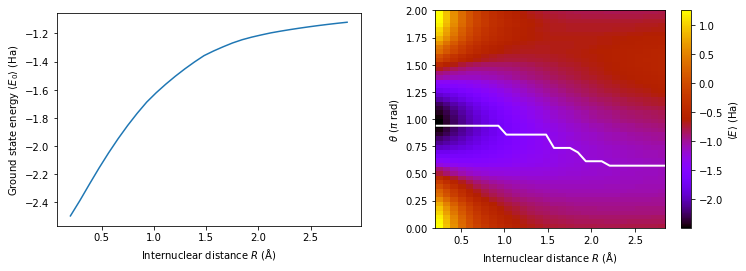

In [20]:
plot_results(R_range,theta_range,E0_QK,E_QK)

This figure does **not** match figures 2 and 3 of [O'Malley](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007) and figure 5d from [Xue](https://arxiv.org/abs/2107.00628)!

### OpenFermion

In [21]:
def OpenFermion_gss(molecule, es_problem, distance, expectation_values):
    """Ground state solver using manual energy minimisation"""
    molecule.perturbations = [distance]
    
    # Get Hamiltonian
    Hamiltonian = get_OF_hamiltonian(molecule, symmetry_reduction=True)

    E = 0 # energy expectation as function of theta for specific R in Ha
    for key in Hamiltonian:
        E += np.real(Hamiltonian[key]*expectation_values[key])
        
    return min(E), list(E)

In [22]:
# Calculate energy expectation values and ground state energies
E0_OF = np.zeros(R_points); E_OF = np.zeros((theta_points,R_points))
for i,dis in enumerate(R_range):
    E0_OF[i], E_OF[:,i] = OpenFermion_gss(molecule, es_problem, dis, expectation_values)

In [23]:
# Save results
array_save = np.vstack([np.insert(R_range,0,0),np.concatenate((theta_range.reshape(-1, 1), E_OF), axis=1)])
np.savetxt('OpenFermion_energies.txt', array_save)

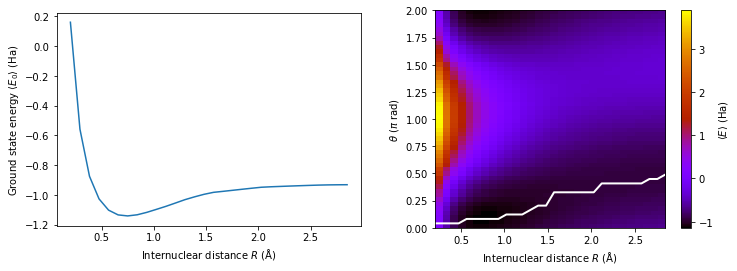

In [24]:
plot_results(R_range,theta_range,E0_OF,E_OF)

This figure matches figures 2 and 3 of [O'Malley](https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031007) and figure 5d from [Xue](https://arxiv.org/abs/2107.00628)

## Hamiltonian Comparison

Blue = Qiskit, Orange = OpenFermion

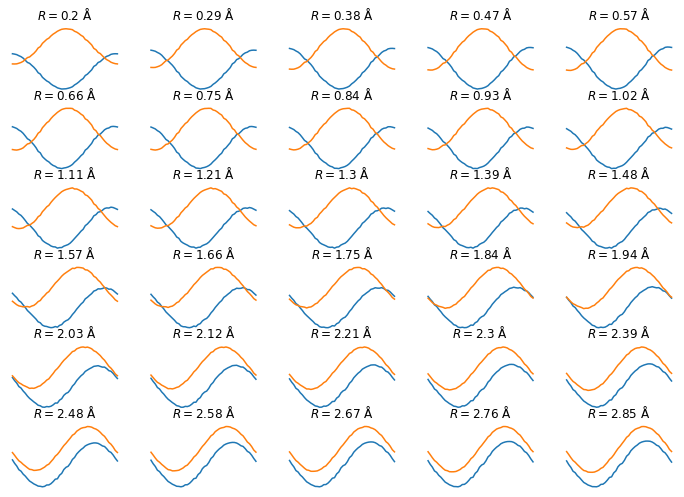

In [26]:
plt.figure(figsize=(12,10))
for i in range(R_points):
    plt.subplot(int(np.ceil(np.sqrt(R_points)+1)),int(np.sqrt(R_points)),i+1)
    plt.title(r"$R=$"+str(round(R_range[i],2))+" Å")
    plt.plot(theta_range,E_QK[:,i])
    plt.plot(theta_range,E_OF[:,i])
    plt.axis('off')
plt.show()

Hamiltonians are rotated $180^\circ$ and shifted vertically (shift dependent on $R$), as can be seen in the manual fix in the supporting_code.ipynb file where both the theta_range and the energy is mirrorred and a vertical shift is applied to match the two sets of Hamiltonians.

## Qiskit Hamiltonians with nuclear repulsion energy

The new Psi4 driver that qiskit uses, `qiskit_nature.drivers.second_quantization.psi4d.PSI4Driver` does not return the nuclear repulsion energy, which is the $R$-dependent vertical shift needed in the correction of the Hamiltonians talked about under the figure above. The older and depreciated driver, `qiskit_nature.drivers.psi4d.PSI4Driver`, however, does return results if run containing the nuclear_repulsion_energy attribute. 

In [27]:
from qiskit_nature.drivers.psi4d import PSI4Driver as PSI4DriverOld

def Qiskit_gss_with_nre(molecule, es_problem, distance, expectation_values):
    """Ground state solver using manual energy minimisation"""
    molecule.perturbations = [distance]
    
    # Get Hamiltonian
    Hamiltonian = get_QK_hamiltonian(molecule,es_problem,ParityMapper(),True)

    E = 0 # energy expectation as function of theta for specific R in Ha
    for key in Hamiltonian:
        E += np.real(Hamiltonian[key]*expectation_values[key])
    nr_energy = PSI4DriverOld(molecule = molecule).run().nuclear_repulsion_energy
    print(str(nr_energy)+'           ',end='\r')
    E += nr_energy
        
    return min(E), list(E)

In [28]:
# Calculate energy expectation values and ground state energies
E0_QK_cor = np.zeros(R_points); E_QK_cor = np.zeros((theta_points,R_points))
for i,dis in enumerate(R_range):
    E0_QK_cor[i], E_QK_cor[:,i] = Qiskit_gss_with_nre(molecule, es_problem, dis, expectation_values)

/tmp/ipykernel_1840/2752405429.py:13: DeprecationWarning: The PSI4Driver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the PSI4Driver class from qiskit_nature.drivers.second_quantization.psi4d.
  nr_energy = PSI4DriverOld(molecule = molecule).run().nuclear_repulsion_energy
/opt/conda/lib/python3.9/site-packages/qiskit_nature/drivers/psi4d/psi4driver.py:81: DeprecationWarning: The HFMethodType enum is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the HFMethodType enum from qiskit_nature.drivers.second_quantization.
  hf_method = HFMethodType.RHF
/opt/conda/lib/python3.9/site-packages/qiskit_nature/drivers/psi4d/psi4driver.py:85: DeprecationWarning: The BaseDriver class is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the BaseDriver class from qiskit_nature.drivers.second_quantization.
  super().__init

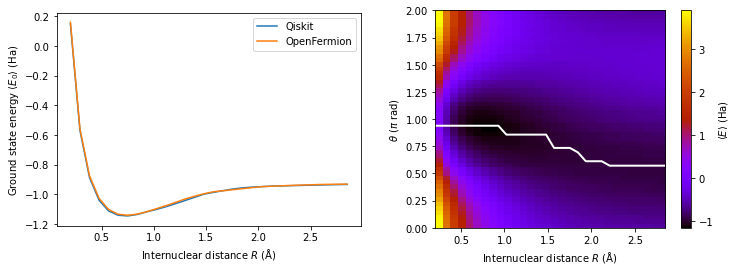

In [29]:
plot_results(R_range,theta_range,E0_QK_cor,E_QK_cor,label="Qiskit",additional_curves=[(E0_OF,"OpenFermion")])

The nuclear repulsion energy provides the vertical shift, but the sets of Hamiltonians still differ, with respect to the $\theta$ axis. This however is logical, considering the Hamiltonians themselves consist of a different set of weights and operators due to the different transformation and mapping processes.